# Requirements

In [274]:
# Add as many imports as you need.

# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of Spotify user reviews. The dataset contains two attributes:

+ **review** - A text column containing user feedback, opinions, and experiences with the Spotify application.
+ **sentiment** - A categorical column indicating whether the review has a positive or negative sentiment.

Your task involves training a model to predict the **sentiment** (either "positive" or "negative") based on the content of the **review**.

## The Spotify User Reviews Dataset

Load the dataset using the `datasets` library.

In [275]:
# Write your code here. Add as many boxes as you need.
import numpy as np
import pandas as pd

from datasets import Dataset, load_dataset

from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


import evaluate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [276]:
# from datasets import load_dataset
# 
# dataset = load_dataset("csv", data_files="/Users/gorazdfilipovski/PycharmProjects/VNP/LABS/lab4/moja_lab_26.12/spotify-user-reviews.csv")
# dataset

In [277]:
df = pd.read_csv("./spotify-user-reviews.csv")
df

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
3,"Works great just with the car's Bluetooth, but...",negative
4,Best music app so far,positive
...,...,...
9995,All of a sudden the app will not work on my S22+,negative
9996,THE BEST MUSIC APP EVER! I WOULD GIVE IT INFIN...,positive
9997,I used to love this app..even though it had so...,negative
9998,Great app. Wish I could add multiple tracks fr...,negative


In [278]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

In [279]:
df["label"]

0       1
1       0
2       1
3       0
4       1
       ..
9995    0
9996    1
9997    0
9998    0
9999    0
Name: label, Length: 10000, dtype: int64

In [280]:
from datasets import Dataset
import pandas as pd
dataset = Dataset.from_pandas(df[:500])

# To verify
print(dataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 500
})


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [281]:
# Write your code here. Add as many boxes as you need.
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 400
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 100
    })
})

In [282]:
dataset["train"].features

{'review': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [283]:
# from transformers import AutoTokenizer, DataCollatorWithPadding
# 
# checkpoint = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# tokenized_texts = tokenizer(dataset["train"]["review"])

In [284]:
def tokenize(sample):
    return tokenizer(sample["review"], truncation=True, padding=True)

In [285]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [286]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 400
    })
    test: Dataset({
        features: ['review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100
    })
})

## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [287]:
# Write your code here. Add as many boxes as you need.
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the traning parameters using the `TrainingArguments` class.

In [288]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=1
)

In [289]:
import evaluate

import evaluate
import numpy as np

metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [290]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Define the training using the `Trainer` class.

In [291]:
# Write your code here. Add as many boxes as you need.
# Write your code here. Add as many boxes as you need.
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Fine-tune (train) the pre-trained lanugage model.

In [292]:
# Write your code here. Add as many boxes as you need.
import torch
torch.cuda.is_available()

False

In [293]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [294]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Use the trained model to make predictions for the test set.

In [295]:
# Write your code here. Add as many boxes as you need.
trainer.train()


Epoch,Training Loss,Validation Loss,F1
1,No log,0.342300,0.889835


TrainOutput(global_step=50, training_loss=0.535837287902832, metrics={'train_runtime': 25.4948, 'train_samples_per_second': 15.689, 'train_steps_per_second': 1.961, 'total_flos': 42961102008000.0, 'train_loss': 0.535837287902832, 'epoch': 1.0})

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [296]:
# Write your code here. Add as many boxes as you need.
predictions = trainer.predict(tokenized_dataset["test"])


In [297]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [298]:
preds

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0])

In [299]:
print(classification_report(labels, preds))


              precision    recall  f1-score   support

           0       0.93      0.84      0.89        51
           1       0.85      0.94      0.89        49

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



Text(0.5, 1.0, 'Confusion Matrix')

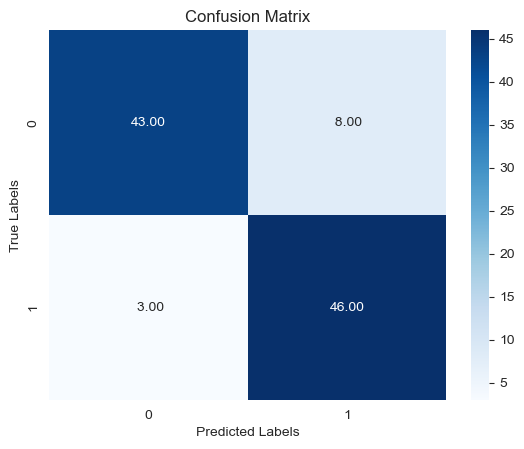

In [300]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a machine learning pipeline to classify Spotify user reviews as positive or negative. Use TF-IDF vectorization to transform the review text into numerical features, and train a logistic regression model on the transformed data. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. To gain insights into the most influential words or phrases associated with positive and negative reviews, analyze the coefficients from the logistic regression model trained on the TF-IDF features. Present the top keywords for each sentiment in a table or a bar chart to provide a clear understanding of the terms driving user feedback.

In [301]:
# Write your code here. Add as many boxes as you need.

In [302]:
data = pd.read_csv("./spotify-user-reviews.csv")

In [303]:
data

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
3,"Works great just with the car's Bluetooth, but...",negative
4,Best music app so far,positive
...,...,...
9995,All of a sudden the app will not work on my S22+,negative
9996,THE BEST MUSIC APP EVER! I WOULD GIVE IT INFIN...,positive
9997,I used to love this app..even though it had so...,negative
9998,Great app. Wish I could add multiple tracks fr...,negative


In [304]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data['review'],  data['label'], test_size=0.2)

In [305]:
X_train

9254    This app need to be fixed. It doesn't let me t...
1561                                                 Good
1670                        Super music player i enjoy it
6087    I love music and I like that I can I mean love...
6669    it is easy to get on this app. and alot of mus...
                              ...                        
5734    Its a good app because if you are sad mood thi...
5191    Easy to make a playlist of your favorite artists.
5390                     Very good and nice app for music
860            Great selections and app is user friendly.
7270    I really enjoy the company of spotify . Thank ...
Name: review, Length: 8000, dtype: object

In [308]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

vectorizer  = TfidfVectorizer()
classificator = LogisticRegression()

model = make_pipeline(vectorizer, classificator)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [309]:

from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(Y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

   negative       0.85      0.88      0.85      0.87      0.86      0.75       990
   positive       0.88      0.85      0.88      0.86      0.86      0.75      1010

avg / total       0.87      0.86      0.87      0.86      0.86      0.75      2000



In [316]:
pd.DataFrame({
    "terms": vectorizer.get_feature_names_out(),
    "coeffs": classificator.coef_[0],
}).nsmallest(10, "coeffs")

,terms,coeffs
2779,fix,-3.658682
4776,not,-3.528561
553,annoying,-3.064332
351,ads,-2.904663
7499,update,-2.887510
7896,worst,-2.856310
7808,why,-2.664985
2165,doesn,-2.550402
1166,but,-2.406378
4898,only,-2.313535
